#### Pregunta 2:
## Back-propagation (BP) from Scratch

A continuación, se definen las funciones de activación y pérdida y auxiliares a utilizar en la red FF a definir.

Activación de la capa Oculta: Sigmoid
\begin{align}
\sigma(z) & = \frac{1}{1+e^{-z}} \\
          & = \frac{e^{z}}{1+e^{z}} \\
\sigma'(z) & = \sigma(z)(1-\sigma(z)) \\
\end{align}
                              
Activación capa Salida: Softmax
\begin{align}
\sigma(\mathbf{z})_j & = \frac{e^{z_j}}{\sum_{i} e^{z_i}} \\
\sigma'(\mathbf{z})_j & = \sigma(\mathbf{z})_j(1-\sigma(\mathbf{z})_j) \\
\end{align}

Función de pérdida (func. objetivo): Cross Entropy

\begin{align}
L(y_p,y_t) & = \sum_{j}(y_{t_j}ln(y_{p_j}) + (1-y_{t_j})ln(1-y_{p_j})) \\
\dfrac{\partial L}{\partial y_p} & = \frac{y_t-y_p}{y_p(1-y_p)} \\
\end{align}

In [10]:
import numpy as np

#definicion sigmoid para capa oculta
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

#derivada de la sigmoidal
def grad_sigmoid(x):
    g = sigmoid(x)
    return g*(1-g)

#definicion linear para capa oculta (alternativa)
def linear(x):
    return x
#derivada de la lineal (alternativa)
def grad_linear(x):
    return (x+1)/(x+1) #vector de 1s. Se suma 1 para evitar posibles divisiones por cero

#definicion softmax para capa de salida
def softmax(vector_x):
    e = np.exp(np.array(vector_x))
    return e/np.sum(e)
#gradiente de softmax
def grad_softmax(vector_x):
    g = softmax(vector_x)
    return g*(1-g)   

#definicion cross entropy como función de pérdida (NECESITA VECTORES ESCALADOS EN EL INTERVALO [0, 1])
def cross_entropy(predicted_vectors, true_vectors):
    predicted_vectors = np.maximum(1e-15,predicted_vectors)
    return -(1.0/len(true_vectors))*np.sum(np.sum((true_vectors*np.log(predicted_vectors) + (1-true_vectors)*np.log(1-predicted_vectors))))
    #return sum((true_vector*np.log(predicted_vector) + (1-true_vector)*np.log(1-predicted_vector)))

#gradiente de cross entropy (respecto a predicted_vector)(NECESITA VECTORES ESCALADOS EN EL INTERVALO [0, 1])
def grad_cross_entropy(predicted_vector, true_vector):
    predicted_vector = np.maximum(1e-15,predicted_vector)
    return -1.0*(true_vector-predicted_vector)/np.dot(predicted_vector,(1-predicted_vector))

#definicion de transformador de vector al tipo one-hot (para salida softmax). Se usará en el método clasificar()
def onehot(input_v):
    output_v = []
    for elem in input_v:        
        if(elem < np.max(input_v)):
            output_v.append(0)
        else:
            output_v.append(1)
    return output_v
        

A continuación, se define la clase red_ff, cuyo constructor inicializa los pesos de la red con valores float aleatorios entre 0.0 y 1.0. Así también, son definidos los métodos forward_pass, medir_error, backward_pass, que constituyen los métodos necesarios para el entrenamiento de la red.

La rutina de entrenamiento (definida dentro de la clase) toma el conjunto de entrenamiento (X, y) y lo itera por completo y en orden aleatorio, aplicando forward pass y luego backward pass a cada uno. Este procedimiento se hace tantas veces como epochs se indiquen, y con cada epoch terminado se guarda el valor de la función de pérdida resultante y el porcentaje de error de clasificación que la red experimentó en esa iteración, retornándolos al finalizar el entrenamiento.

El orden aleatorio del recorrido de los ejemplos es porque se sospechaba que el iterar sobre el ejemplo ordenado (por clases, pues así viene por defecto en las semillas utilizadas) afectaba al entrenamiento, al menos en los primeros epochs. Esto pues, para las primera parte de la iteración (sólo ejemplos de la clase 1), los pesos que beneficiaban esa salida eran muy priorizados en comparación al resto, generando overfitting de forma precoz. Cuando se empezaba a iterar sobre los ejemplos de la clase 2 en el mismo epoch, el aprendizaje tendía a ser más errático (backward passes bien grandes). Sin embargo, con el entrenamiento suficiente, ambas formas de recorrer el conjunto de entrenamiento deberían converger a algún óptimo. Esto se menciona, pero no se probó de forma empírica, pues no se pidió y se escapa del alcance del ítem.

El método clasificar toma el conjunto de inputs (que debe ser previamente vectorizado), aplica un forward pass por cada input, y retorna una clasificación para cada uno, en forma vectorizada y one-hot, esto para transformar las probabilidades de la salida de la red a un vector que representa la clasificación como tal.

In [3]:
class red_ff:    
    def __init__(self, I, H, O):
        self.pesos_capa_entrada, self.pesos_capa_oculta = self.inicializar_pesos(I, H, O)
    
    def inicializar_pesos(self, tamano_entrada, tamano_capa_oculta, tamano_capa_salida):
        pce = []
        pco = []
        #version simple
        pce = np.array([[1.0]*tamano_capa_oculta]*(tamano_entrada+1)) #el +1 es para incluir el bias en la matriz peso y en el vector entrada
        pco = np.array([[1.0]*tamano_capa_salida]*(tamano_capa_oculta+1)) #el +1 es para incluir el bias de la matriz pesos capa oculta
        #TO DO: proponer inicializacion mas apropiada
        #version de asignar random entre 0.0 y 1.0 a cada peso de las matrices
        import random
        for i in range(len(pce)):
            for j in range(len(pce[i])):
                pce[i][j] = random.random()
        for i in range(len(pco)):
            for j in range(len(pco[i])):
                pco[i][j] = random.random()
        return pce, pco
    
    def forward_pass(self, vector_ejemplo, clase_ejemplo):
        self.activaciones_capa_oculta = sigmoid(np.dot(np.transpose(self.pesos_capa_entrada), np.append(vector_ejemplo, 1)))
        #self.activaciones_capa_oculta = linear(np.dot(np.transpose(self.pesos_capa_entrada), np.append(vector_ejemplo, 1)))
        self.activaciones_capa_salida = softmax(np.dot(np.transpose(self.pesos_capa_oculta), np.append(self.activaciones_capa_oculta, 1)))
        #gradientes de las activaciones
        self.gradientes_activaciones_capa_oculta = grad_sigmoid(self.activaciones_capa_oculta)
        #self.gradientes_activaciones_capa_oculta = grad_linear(self.activaciones_capa_oculta)
        self.gradientes_activaciones_capa_salida = grad_softmax(self.activaciones_capa_salida)
        """print "a_h:"
        print self.activaciones_capa_oculta
        print "(a_h)':"
        print self.gradientes_activaciones_capa_oculta"""
        #print "yo:"
        #print self.activaciones_capa_salida
        """print "(yo)':"
        print self.gradientes_activaciones_capa_salida"""
    
    def medir_error(self, clases_predichas, clases_ejemplo): #devuelve el valor de la func. objetivo
        return cross_entropy(clases_predichas, clases_ejemplo)
    
    def backward_pass(self, tasa_aprend, vector_ejemplo, clase_ejemplo):
        #dEdyo arreglo de tamaño O
        dEdyo = grad_cross_entropy(self.activaciones_capa_salida, clase_ejemplo)
        #print "dEdyo:"
        #print dEdyo
        #dEdzo arreglo tamaño O
        dEdzo = dEdyo*self.gradientes_activaciones_capa_salida.copy()
        #dEdwj arreglo tamaño H
        #dEdwj = self.activaciones_capa_oculta*dEdzo
        dEdyh = []
        #dEdWo matriz de gradientes del error E respecto de la matriz de pesos de salida Wo
        dEdWo = []
        #ciclo for se repite H veces
        for i in range(len(self.activaciones_capa_oculta)):
            dEdyh.append(np.sum(self.pesos_capa_oculta[i]*dEdzo.copy()))
            dEdWo.append(self.gradientes_activaciones_capa_oculta[i]*dEdzo.copy())
        #iteracion adicional para dEdWo: agregar ultima fila igual a 1*dEdzo. Esto es para considerar el bias
        dEdWo.append(dEdzo)
        dEdyh = np.array(dEdyh)
        dEdWo = np.array(dEdWo)
        #dEdyh arreglo de tamaño H
        #dEdWo matriz de tamaño (H+1) x O
        #corrección de matriz de pesos Wo (matriz de pesos entre la capa oculta y la de salida)
        self.pesos_capa_oculta -= tasa_aprend*dEdWo
        #a partir de aqui se corregira la matriz de pesos de la capa de entrada Wi
        #dEdzi arreglo de tamaño H
        dEdzi = dEdyh*self.gradientes_activaciones_capa_oculta.copy()
        dEdWi = []
        #iteracion sobre dEdzi. Se repite H veces
        for val in dEdzi:
            dEdWi.append(val*np.append(vector_ejemplo, 1))
        #dEdWi matriz de tamaño H x (d+1), d: dimension de la entrada, el +1 es por el bias
        #se transpone para coincidir con la matriz de pesos ((d+1 x H)
        dEdWi = np.transpose(np.array(dEdWi))
        #correccion de matriz de pesos Wi
        self.pesos_capa_entrada -= tasa_aprend*dEdWi
    
    def entrenar(self, conjunto_x, conjunto_y, tasa_aprendizaje, epochs):
        #rutina de entrenamiento
        if(len(conjunto_x) != len(conjunto_y)):
            print "Conjunto de entrenamiento incorrecto."
            return
        #los pesos se inicializan en el constructor de la clase red_ff
        error_per_epoch = []
        loss_per_epoch = []
        train_set = []
        for i in range(len(conjunto_x)):
            train_set.append((conjunto_x[i],conjunto_y[i]))
        
        for i in range(epochs):
            np.random.shuffle(train_set) #ejemplos ya no estan ordenados por clase (sospecho que afectaba el entrenamiento)       
            outputs = []
            for x_train, y_train in train_set:
                self.forward_pass(x_train, y_train)
                outputs.append(self.activaciones_capa_salida)
                #no se chequea error E como criterio de parada
                #print "Error total epoch "+str(i+1)+", ejemplo "+str(j)+": "+str(self.medir_error(y_train))
                self.backward_pass(tasa_aprendizaje, x_train, y_train)            
            loss_per_epoch.append(self.medir_error(np.array(outputs),np.array(conjunto_y)))            
            #print loss_per_epoch
            a,b,c = self.clasificar(conjunto_x, conjunto_y)
            error_per_epoch.append(1.0-b)
            #print b
            #print "Loss epoch "+str(i+1)+": "+str(loss_per_epoch[-1])
            #print "Accuracy epoch "+str(i+1)+": "+str(float(np.sum(b))/len(b))
        return loss_per_epoch, error_per_epoch
                
    def clasificar(self, x_test, y_test):
        test_set = []
        for i in range(len(x_test)):
            test_set.append((x_test[i],y_test[i]))
        y_pred = []
        prediccion_correcta = 0
        loss_func = []
        for x_t,y_t in test_set:
            self.forward_pass(x_t,y_t)
            y_pred.append(onehot(self.activaciones_capa_salida))            
            if(y_pred[-1]==y_t.tolist()): #si la clasificacion predicha es correcta:
                prediccion_correcta += 1
            loss_func.append(self.medir_error(self.activaciones_capa_salida,y_t))
        """for i in range(len(y_pred)):
            for j in range(len(y_pred[0])):
                if (y_pred[i][j]!=y_test[i][j]):
                    continue
                else:
                    prediccion_correcta += 1"""

        prediccion_correcta = float(prediccion_correcta)/len(y_pred)
        
        return y_pred, prediccion_correcta, loss_func

A continuación, se genera el conjunto de entrenamiento para poner en marcha la red.
El conjunto X_train es un arreglo de vectores de largo 7. Esto es, el input de la red es de dimensión 7. También, se procede a escalar X_train usando StandardScaler, que hace que la media del conjunto sea igual a cero, y su varianza 1. Este preprocesamiento es recomendable, pues propicia un aprendizaje de mejor comportamiento, al impedir que aparezcan números muy grandes que puedan contribuir a la saturación temprana de la red.
y_train no viene vectorizado por defecto, por lo que se transforma a vectores one-hot antes de usarlos en la rutina de entrenamiento.

In [4]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pd.read_csv(url, sep=r'\s+',header=None)
X_train = df.ix[: ,0:6]
y_train = df.ix[:,7]

In [5]:
#X_train = MinMaxScaler().fit_transform(X_train)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

y_train_vec = []
for clase in y_train:
    if(clase==np.int64(1)):
        y_train_vec.append([1,0,0])
    elif(clase==np.int64(2)):
        y_train_vec.append([0,1,0])
    elif(clase==np.int64(3)):
        y_train_vec.append([0,0,1])
    else:
        print "Error: hay mas de 3 clases"
        

Finalmente, se crea una red instanciando la clase definida. Como se mencionó anteriormente, la dimensión de la entrada será igual a 7, y la salida de dimensión 3, pues existen 3 clases. Se define la capa oculta para que posea 20 neuronas. Se experimentó con cantidades distintas de neuronas, pero no generaron mayor mejora en el rendimiento del aprendizaje del que lo hizo la variación del learning rate (resultados de rendimiento no se exponen, pues se escapan del alcance de la actividad). 
Inmediatamente después, se pone a entrenar la red con el conjunto de entrenamiento definido en el bloque anterior, usando un learning rate de 0.005, y 100 epochs. Se captura el loss por epoch y el porcentaje de error de clasificación de cada epoch en las variables loss y error, respectivamente.

In [11]:
red = red_ff(7, 20, 3)

loss, error = red.entrenar(np.array(X_train), np.array(y_train_vec), 0.005, 100)

Luego, podemos ver gráficamente el comportamiento de la red a medida que se entrena. En el primer gráfico, se puede ver el loss versus la cantidad de epochs, y en el segundo se aprecia el porcentaje de errores en la clasificación durante el entrenamiento, versus la cantidad de epochs. Es extraño notar que, si bien el loss no tiende a decrecer con la cantidad de epochs, sí lo hace el porcentaje de error de clasificación. También, a partir del epoch 90, aproximadamente, el error de clasificación comienza a crecer.

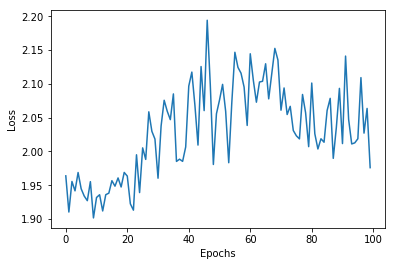

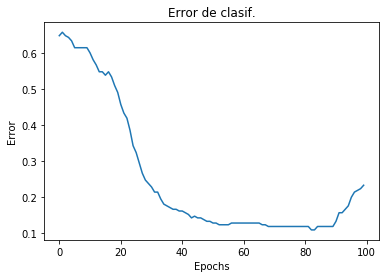

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(100), loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,0.7)
plt.show()
plt.clf()

#plt.figure(figsize=(12,6))
plt.title("Error de clasif.")
plt.plot(range(100),error)
plt.xlabel('Epochs')
plt.ylabel('Error')
#plt.ylim(0,0.7)
plt.show()

Si bien se revisó tanto la implementación de la función de pérdida como su uso en el método clasificar(), no se encontró ningún error que pudiera explicar el crecimiento del loss.

Descartando errores en la implementación de la función de pérdida, y considerando, además, el crecimiento del error de clasificación al final del entrenamiento, concluímos que el comportamiento de la red es divergente.

Es importante mencionar que, para lograr resultados en la rutina de entrenamiento, se tuvo que añadir casos de borde a las definiciones de la función de pérdida cross_entropy() y grad_cross_entropy(). Estos casos consideraban, para todo elemento del vector predicho, que éstos no fueran más cercanos al cero que 10^-15, y en caso de serlo, se les asignaba ese valor. Esta consideración fue incluida para evitar que los números se salieran de su límite de precisión y que éstos fueran aproximados a cero, lo cual indefinía las funciones de pérdida y su gradiente de forma explosiva, saturando por completo la red. La búsqueda y hallazgo de esta limitación nos costó días, pues no existían indicios que nos permitieran sospechar sobre ella, ni siquiera en la comunidad Web.

A pesar de haber agregado la consideración mencionada, encontramos que la red diverge si el learning rate es mayor del orden de las milésimas. Creemos que el uso de funciones logarítmicas influyeron de forma inesperada en este comportamiento. Podría solucionarse la divergencia agregando más consideraciones similares en pasos en los que exista riesgo de explosión en los parámetros, aunque, insistimos, esto no debería ser necesario, pues se revisó toda la implementación, tanto de forward como backward pass, y se re escribió este último varias veces buscando corregir errores de planteamiento, lo cual no dio resultado hasta haber considerado el caso borde mencionado.

Weight decay